<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_VIT_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 2s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


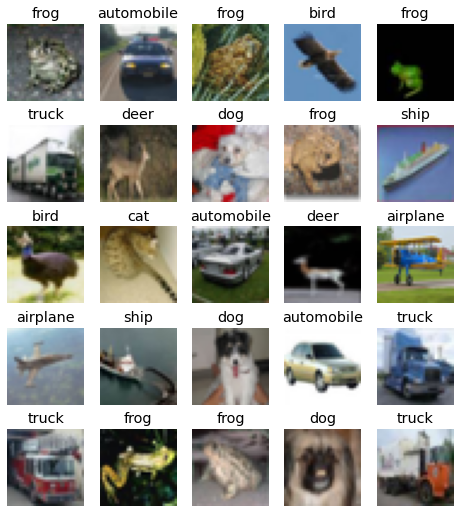

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


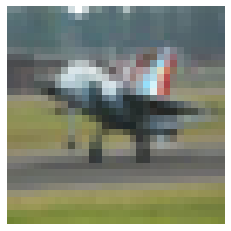

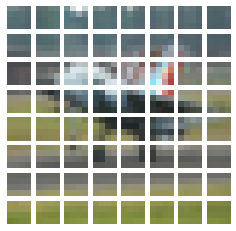

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) .

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

Save an initial copy of the weights.  
The weights will be used to initialize all the experiments, allowing for fair comparison.


In [9]:
%%script false 
# Kept as reference.

# # Saves a full copy of the model.
# model_SmallCNN = SmallCNN(num_classes=10, 
#                           image_height=32, 
#                           image_width=32,
#                           preprocess=False).model()
# model_SmallCNN.save('model_SmallCNN')

# # Loads model
# model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
# model_SmallCNN.summary()

# # Saves a full copy of the model.
# model_VIT = VIT(num_classes=10, 
#                 image_height=32, 
#                 image_width=32,
#                 patch_size=4, 
#                 projection_dim=32,
#                 num_layers=4,
#                 num_heads=4,
#                 mlp_dims=[64, 32],
#                 classifier_mlp_dims=[512],
#                 preprocess=False).model()
# model_VIT.save('model_VIT')

# # Loads model
# model_VIT = tf.keras.models.load_model('model_VIT')
# model_VIT.summary()

# # Saves only the weights of the model.
# model = SmallCNN(num_classes=10)
# model(tf.zeros([1,32,32,3]))
# model.save_weights('model.h5')

# # Loads weights
# model.load_weights('model.h5')
# model.preprocess = True
# for layer in model.model().layers:
#   print(layer.output)
# model.model().summary()

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [11]:
def train_and_eval(_model, _checkpoint_filepath):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    _checkpoint_filepath,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
  )

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(_checkpoint_filepath, 'logs'), 
    histogram_freq=epochs//10,
    update_freq='epoch'
  )

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[tensorboard_callback, checkpoint_callback],
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  # Save history output, should be the same as the tensorboard logs.
  np.save(os.path.join(_checkpoint_filepath, 'history.npy'), history.history)

  return history

Native TF with GradientTape.  
This is exactly the same as using compite(...) and fit(...) in keras.  
However, this exposes the gradient and the train loop, allowing for more flexibility.

In [12]:
%%script false
# This is just for reference.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = acc_metric_fn(name='sparse_categorical_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = acc_metric_fn(name='val_sparse_categorical_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
progbar = tf.keras.utils.Progbar
trn_ds = data_generator('train', batch_size, shuffle_buffer)
val_ds = data_generator('val', batch_size)

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = progbar(steps_per_epoch=len(trn_ds), 
                 stateful_metrics=['Loss', 'Accuracy',
                                   'Val Loss', 'Val Accuracy'])
  
  for idx, (images, labels) in enumerate(trn_ds):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

print(f'Total training time {end - start} seconds')

# Loss and accuracy plots

In [2]:
def plot(losses: list, 
         accuracies: list, 
         legend_labels: list, 
         subplot_title: list):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  
  for x, ll in zip(losses, legend_labels):
    c = ax1.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax1.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()   

  for x, ll in zip(accuracies, legend_labels):
    c = ax2.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax2.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()   

  plt.show()

#Experiments

In [14]:
history = dict()

**Experiment 1**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 1

In [15]:
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=1,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
train_and_eval(model, SAVE_PATH + 'VIT_4x4_1hd')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 2/50
196/196 [==============================] - 5s 27ms/step - loss: 1.7887 - sparse_categorical_accuracy: 0.3464 - val_loss: 1.4799 - val_sparse_categorical_accuracy: 0.4630


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 3/50
196/196 [==============================] - 5s 27ms/step - loss: 1.5961 - sparse_categorical_accuracy: 0.4207 - val_loss: 1.3715 - val_sparse_categorical_accuracy: 0.4996


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 4/50
196/196 [==============================] - 5s 27ms/step - loss: 1.4893 - sparse_categorical_accuracy: 0.4630 - val_loss: 1.3198 - val_sparse_categorical_accuracy: 0.5248


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 5/50
196/196 [==============================] - 5s 27ms/step - loss: 1.4262 - sparse_categorical_accuracy: 0.4836 - val_loss: 1.2427 - val_sparse_categorical_accuracy: 0.5488


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 6/50
196/196 [==============================] - 5s 27ms/step - loss: 1.3604 - sparse_categorical_accuracy: 0.5064 - val_loss: 1.2120 - val_sparse_categorical_accuracy: 0.5641


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 7/50
196/196 [==============================] - 5s 27ms/step - loss: 1.3263 - sparse_categorical_accuracy: 0.5218 - val_loss: 1.1615 - val_sparse_categorical_accuracy: 0.5752


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 8/50
196/196 [==============================] - 5s 27ms/step - loss: 1.2838 - sparse_categorical_accuracy: 0.5329 - val_loss: 1.1414 - val_sparse_categorical_accuracy: 0.5900


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 9/50
196/196 [==============================] - 5s 27ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.5446 - val_loss: 1.1057 - val_sparse_categorical_accuracy: 0.6012


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 10/50
196/196 [==============================] - 5s 27ms/step - loss: 1.2090 - sparse_categorical_accuracy: 0.5672 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6120


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 11/50
196/196 [==============================] - 5s 27ms/step - loss: 1.1945 - sparse_categorical_accuracy: 0.5686 - val_loss: 1.0711 - val_sparse_categorical_accuracy: 0.6136


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 12/50
196/196 [==============================] - 5s 27ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.5865 - val_loss: 1.0464 - val_sparse_categorical_accuracy: 0.6243


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 13/50
196/196 [==============================] - 5s 27ms/step - loss: 1.1390 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.0430 - val_sparse_categorical_accuracy: 0.6332


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 14/50
196/196 [==============================] - 5s 27ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.6020 - val_loss: 1.0158 - val_sparse_categorical_accuracy: 0.6400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 15/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0786 - sparse_categorical_accuracy: 0.6138 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.6527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 16/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0638 - sparse_categorical_accuracy: 0.6175 - val_loss: 0.9716 - val_sparse_categorical_accuracy: 0.6515
Epoch 17/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0442 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.6617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 18/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0251 - sparse_categorical_accuracy: 0.6317 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.6614
Epoch 19/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0027 - sparse_categorical_accuracy: 0.6463 - val_loss: 0.9467 - val_sparse_categorical_accuracy: 0.6620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 20/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9943 - sparse_categorical_accuracy: 0.6454 - val_loss: 0.9286 - val_sparse_categorical_accuracy: 0.6706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 21/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9575 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.9341 - val_sparse_categorical_accuracy: 0.6701
Epoch 22/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9465 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.9267 - val_sparse_categorical_accuracy: 0.6701
Epoch 23/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9281 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.9051 - val_sparse_categorical_accuracy: 0.6789


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 24/50
196/196 [==============================] - 5s 27ms/step - loss: 0.9293 - sparse_categorical_accuracy: 0.6704 - val_loss: 0.8917 - val_sparse_categorical_accuracy: 0.6860


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 25/50
196/196 [==============================] - 5s 28ms/step - loss: 0.8891 - sparse_categorical_accuracy: 0.6837 - val_loss: 0.8892 - val_sparse_categorical_accuracy: 0.6867


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 26/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8768 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.8848 - val_sparse_categorical_accuracy: 0.6911


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 27/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8727 - sparse_categorical_accuracy: 0.6914 - val_loss: 0.8774 - val_sparse_categorical_accuracy: 0.6902
Epoch 28/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8532 - sparse_categorical_accuracy: 0.6957 - val_loss: 0.8803 - val_sparse_categorical_accuracy: 0.6892
Epoch 29/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8394 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.8527 - val_sparse_categorical_accuracy: 0.6985


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 30/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8211 - sparse_categorical_accuracy: 0.7081 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.7015


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 31/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8076 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.8398 - val_sparse_categorical_accuracy: 0.7063


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 32/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7978 - sparse_categorical_accuracy: 0.7176 - val_loss: 0.8433 - val_sparse_categorical_accuracy: 0.7032
Epoch 33/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7999 - sparse_categorical_accuracy: 0.7140 - val_loss: 0.8437 - val_sparse_categorical_accuracy: 0.7036
Epoch 34/50
196/196 [==============================] - 5s 26ms/step - loss: 0.7846 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.8291 - val_sparse_categorical_accuracy: 0.7078


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 35/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7669 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.8258 - val_sparse_categorical_accuracy: 0.7083


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 36/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.8178 - val_sparse_categorical_accuracy: 0.7136


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 37/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7477 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.8302 - val_sparse_categorical_accuracy: 0.7138


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 38/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.8308 - val_sparse_categorical_accuracy: 0.7119
Epoch 39/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7397 - val_loss: 0.8154 - val_sparse_categorical_accuracy: 0.7184


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 40/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.8112 - val_sparse_categorical_accuracy: 0.7177
Epoch 41/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.8110 - val_sparse_categorical_accuracy: 0.7165
Epoch 42/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6893 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.7188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 43/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6899 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7232


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 44/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6680 - sparse_categorical_accuracy: 0.7634 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.7267


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Epoch 45/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6736 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.7221
Epoch 46/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.7703 - val_loss: 0.8057 - val_sparse_categorical_accuracy: 0.7206
Epoch 47/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6607 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.7960 - val_sparse_categorical_accuracy: 0.7237
Epoch 48/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.7726 - val_loss: 0.8069 - val_sparse_categorical_accuracy: 0.7215
Epoch 49/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.7966 - val_sparse_categorical_accuracy: 0.7239
Epoch 50/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6375 - spars

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/assets


Total training time 513.8743381500244 seconds


**Experiment 2**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 1, 2  
Projections : 32 only, 64 only

In [16]:
for hds in [1, 2]:
  for proj in [32, 64]:
    model = VIT(num_classes=num_classes, 
                image_height=image_height, 
                image_width=image_width,
                patch_size=4, 
                projection_dim=proj,
                num_layers=4,
                num_heads=1,
                mlp_dims=[proj, proj],
                classifier_mlp_dims=[512],
                preprocess=False).model()
    model.summary()
    train_and_eval(model, SAVE_PATH + f'VIT_4x4_{hds}hd_{proj}proj')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7389 - sparse_categorical_accuracy: 0.3574 - val_loss: 1.4401 - val_sparse_categorical_accuracy: 0.4795


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 3/50
196/196 [==============================] - 5s 23ms/step - loss: 1.5770 - sparse_categorical_accuracy: 0.4286 - val_loss: 1.3738 - val_sparse_categorical_accuracy: 0.4991


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 4/50
196/196 [==============================] - 5s 23ms/step - loss: 1.4808 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.3046 - val_sparse_categorical_accuracy: 0.5338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 5/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4158 - sparse_categorical_accuracy: 0.4853 - val_loss: 1.2675 - val_sparse_categorical_accuracy: 0.5414


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3708 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.2178 - val_sparse_categorical_accuracy: 0.5576


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 7/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3199 - sparse_categorical_accuracy: 0.5248 - val_loss: 1.1826 - val_sparse_categorical_accuracy: 0.5709


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 8/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2910 - sparse_categorical_accuracy: 0.5349 - val_loss: 1.1531 - val_sparse_categorical_accuracy: 0.5850


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 9/50
196/196 [==============================] - 5s 23ms/step - loss: 1.2560 - sparse_categorical_accuracy: 0.5489 - val_loss: 1.1336 - val_sparse_categorical_accuracy: 0.5902


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 10/50
196/196 [==============================] - 5s 23ms/step - loss: 1.2301 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.1116 - val_sparse_categorical_accuracy: 0.6029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 11/50
196/196 [==============================] - 5s 23ms/step - loss: 1.2009 - sparse_categorical_accuracy: 0.5696 - val_loss: 1.0770 - val_sparse_categorical_accuracy: 0.6096


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 12/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1662 - sparse_categorical_accuracy: 0.5822 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.6107


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 13/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.5900 - val_loss: 1.0521 - val_sparse_categorical_accuracy: 0.6222


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 14/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1193 - sparse_categorical_accuracy: 0.6003 - val_loss: 1.0420 - val_sparse_categorical_accuracy: 0.6247


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 15/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.6078 - val_loss: 1.0283 - val_sparse_categorical_accuracy: 0.6281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 16/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0695 - sparse_categorical_accuracy: 0.6189 - val_loss: 1.0088 - val_sparse_categorical_accuracy: 0.6374


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 17/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0448 - sparse_categorical_accuracy: 0.6259 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.6500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 18/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0299 - sparse_categorical_accuracy: 0.6346 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.6425
Epoch 19/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0164 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.6563


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 20/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0022 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.9651 - val_sparse_categorical_accuracy: 0.6600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 21/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9804 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.9593 - val_sparse_categorical_accuracy: 0.6584
Epoch 22/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9622 - sparse_categorical_accuracy: 0.6592 - val_loss: 0.9608 - val_sparse_categorical_accuracy: 0.6589
Epoch 23/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9475 - sparse_categorical_accuracy: 0.6612 - val_loss: 0.9380 - val_sparse_categorical_accuracy: 0.6680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 24/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9227 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.6738


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 25/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9178 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.9350 - val_sparse_categorical_accuracy: 0.6737
Epoch 26/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9065 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.9057 - val_sparse_categorical_accuracy: 0.6801


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 27/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8815 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.6803


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 28/50
196/196 [==============================] - 5s 23ms/step - loss: 0.8809 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.8900 - val_sparse_categorical_accuracy: 0.6871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 29/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8720 - sparse_categorical_accuracy: 0.6897 - val_loss: 0.8988 - val_sparse_categorical_accuracy: 0.6860
Epoch 30/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8499 - sparse_categorical_accuracy: 0.7001 - val_loss: 0.8818 - val_sparse_categorical_accuracy: 0.6884


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 31/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8346 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.8807 - val_sparse_categorical_accuracy: 0.6917


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 32/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8182 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.8737 - val_sparse_categorical_accuracy: 0.6923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 33/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8195 - sparse_categorical_accuracy: 0.7068 - val_loss: 0.8636 - val_sparse_categorical_accuracy: 0.6979


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 34/50
196/196 [==============================] - 5s 23ms/step - loss: 0.7971 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.8844 - val_sparse_categorical_accuracy: 0.6881
Epoch 35/50
196/196 [==============================] - 5s 23ms/step - loss: 0.7882 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8986 - val_sparse_categorical_accuracy: 0.6881
Epoch 36/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7765 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.7022


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 37/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7598 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.8605 - val_sparse_categorical_accuracy: 0.7041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 38/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7567 - sparse_categorical_accuracy: 0.7287 - val_loss: 0.8428 - val_sparse_categorical_accuracy: 0.7050


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 39/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7400 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.8482 - val_sparse_categorical_accuracy: 0.7017
Epoch 40/50
196/196 [==============================] - 5s 23ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.8516 - val_sparse_categorical_accuracy: 0.7044
Epoch 41/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7321 - sparse_categorical_accuracy: 0.7401 - val_loss: 0.8456 - val_sparse_categorical_accuracy: 0.7083


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 42/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7136 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.8449 - val_sparse_categorical_accuracy: 0.7041
Epoch 43/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7146 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.8206 - val_sparse_categorical_accuracy: 0.7106


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 44/50
196/196 [==============================] - 5s 24ms/step - loss: 0.6980 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.8342 - val_sparse_categorical_accuracy: 0.7080
Epoch 45/50
196/196 [==============================] - 5s 24ms/step - loss: 0.6986 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.8277 - val_sparse_categorical_accuracy: 0.7141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 46/50
196/196 [==============================] - 5s 24ms/step - loss: 0.6786 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.8237 - val_sparse_categorical_accuracy: 0.7091
Epoch 47/50
196/196 [==============================] - 5s 23ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.8303 - val_sparse_categorical_accuracy: 0.7086
Epoch 48/50
196/196 [==============================] - 5s 23ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.7132
Epoch 49/50
196/196 [==============================] - 5s 23ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.8157 - val_sparse_categorical_accuracy: 0.7154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Epoch 50/50
196/196 [==============================] - 5s 24ms/step - loss: 0.6612 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/assets


Total training time 492.62294816970825 seconds
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_3 (Patches)             (None, None, 48)     0           resize[0][0]                     
_____________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 2/50
196/196 [==============================] - 8s 40ms/step - loss: 1.9547 - sparse_categorical_accuracy: 0.2588 - val_loss: 1.6188 - val_sparse_categorical_accuracy: 0.4025


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 3/50
196/196 [==============================] - 8s 40ms/step - loss: 1.7376 - sparse_categorical_accuracy: 0.3506 - val_loss: 1.4677 - val_sparse_categorical_accuracy: 0.4570


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 4/50
196/196 [==============================] - 8s 40ms/step - loss: 1.5937 - sparse_categorical_accuracy: 0.4115 - val_loss: 1.3466 - val_sparse_categorical_accuracy: 0.5154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 5/50
196/196 [==============================] - 8s 40ms/step - loss: 1.4941 - sparse_categorical_accuracy: 0.4506 - val_loss: 1.3118 - val_sparse_categorical_accuracy: 0.5299


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 6/50
196/196 [==============================] - 8s 40ms/step - loss: 1.4201 - sparse_categorical_accuracy: 0.4887 - val_loss: 1.2352 - val_sparse_categorical_accuracy: 0.5475


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 7/50
196/196 [==============================] - 8s 40ms/step - loss: 1.3696 - sparse_categorical_accuracy: 0.5084 - val_loss: 1.1883 - val_sparse_categorical_accuracy: 0.5643


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 8/50
196/196 [==============================] - 8s 40ms/step - loss: 1.3268 - sparse_categorical_accuracy: 0.5219 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.5813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 9/50
196/196 [==============================] - 8s 40ms/step - loss: 1.2673 - sparse_categorical_accuracy: 0.5424 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.5846


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 10/50
196/196 [==============================] - 8s 40ms/step - loss: 1.2392 - sparse_categorical_accuracy: 0.5581 - val_loss: 1.0908 - val_sparse_categorical_accuracy: 0.6099


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 11/50
196/196 [==============================] - 8s 40ms/step - loss: 1.1944 - sparse_categorical_accuracy: 0.5735 - val_loss: 1.0567 - val_sparse_categorical_accuracy: 0.6242


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 12/50
196/196 [==============================] - 8s 40ms/step - loss: 1.1527 - sparse_categorical_accuracy: 0.5917 - val_loss: 1.0550 - val_sparse_categorical_accuracy: 0.6253


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 13/50
196/196 [==============================] - 8s 40ms/step - loss: 1.1160 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.0084 - val_sparse_categorical_accuracy: 0.6403


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 14/50
196/196 [==============================] - 8s 40ms/step - loss: 1.0776 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.6523


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 15/50
196/196 [==============================] - 8s 40ms/step - loss: 1.0627 - sparse_categorical_accuracy: 0.6274 - val_loss: 0.9642 - val_sparse_categorical_accuracy: 0.6575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 16/50
196/196 [==============================] - 8s 40ms/step - loss: 1.0168 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.6685


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 17/50
196/196 [==============================] - 8s 41ms/step - loss: 0.9985 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.9327 - val_sparse_categorical_accuracy: 0.6674
Epoch 18/50
196/196 [==============================] - 8s 40ms/step - loss: 0.9582 - sparse_categorical_accuracy: 0.6601 - val_loss: 0.9284 - val_sparse_categorical_accuracy: 0.6779


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 19/50
196/196 [==============================] - 8s 41ms/step - loss: 0.9362 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.9173 - val_sparse_categorical_accuracy: 0.6755
Epoch 20/50
196/196 [==============================] - 8s 40ms/step - loss: 0.9097 - sparse_categorical_accuracy: 0.6782 - val_loss: 0.9046 - val_sparse_categorical_accuracy: 0.6802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 21/50
196/196 [==============================] - 8s 40ms/step - loss: 0.8946 - sparse_categorical_accuracy: 0.6861 - val_loss: 0.8767 - val_sparse_categorical_accuracy: 0.6928


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 22/50
196/196 [==============================] - 8s 41ms/step - loss: 0.8680 - sparse_categorical_accuracy: 0.6970 - val_loss: 0.8620 - val_sparse_categorical_accuracy: 0.6998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 23/50
196/196 [==============================] - 8s 40ms/step - loss: 0.8411 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.8596 - val_sparse_categorical_accuracy: 0.6986
Epoch 24/50
196/196 [==============================] - 8s 40ms/step - loss: 0.8211 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.8407 - val_sparse_categorical_accuracy: 0.7056


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 25/50
196/196 [==============================] - 8s 40ms/step - loss: 0.8040 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.8469 - val_sparse_categorical_accuracy: 0.7012
Epoch 26/50
196/196 [==============================] - 8s 40ms/step - loss: 0.7881 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.8511 - val_sparse_categorical_accuracy: 0.7013
Epoch 27/50
196/196 [==============================] - 8s 40ms/step - loss: 0.7648 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.8177 - val_sparse_categorical_accuracy: 0.7163


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 28/50
196/196 [==============================] - 8s 40ms/step - loss: 0.7504 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.8652 - val_sparse_categorical_accuracy: 0.6976
Epoch 29/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7410 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.8432 - val_sparse_categorical_accuracy: 0.7094
Epoch 30/50
196/196 [==============================] - 8s 40ms/step - loss: 0.7215 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.8107 - val_sparse_categorical_accuracy: 0.7188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 31/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6920 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.7929 - val_sparse_categorical_accuracy: 0.7228


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 32/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6960 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.8075 - val_sparse_categorical_accuracy: 0.7173
Epoch 33/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.7635 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.7226
Epoch 34/50
196/196 [==============================] - 8s 40ms/step - loss: 0.6691 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7246


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 35/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6445 - sparse_categorical_accuracy: 0.7733 - val_loss: 0.7977 - val_sparse_categorical_accuracy: 0.7226
Epoch 36/50
196/196 [==============================] - 8s 40ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.7821 - val_sparse_categorical_accuracy: 0.7260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 37/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6106 - sparse_categorical_accuracy: 0.7860 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.7293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 38/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6084 - sparse_categorical_accuracy: 0.7864 - val_loss: 0.8081 - val_sparse_categorical_accuracy: 0.7267
Epoch 39/50
196/196 [==============================] - 8s 40ms/step - loss: 0.5940 - sparse_categorical_accuracy: 0.7899 - val_loss: 0.7863 - val_sparse_categorical_accuracy: 0.7276
Epoch 40/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.7942 - val_sparse_categorical_accuracy: 0.7296


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 41/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7954 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.7273
Epoch 42/50
196/196 [==============================] - 8s 40ms/step - loss: 0.5659 - sparse_categorical_accuracy: 0.7998 - val_loss: 0.7700 - val_sparse_categorical_accuracy: 0.7349


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 43/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5593 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.7629 - val_sparse_categorical_accuracy: 0.7384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 44/50
196/196 [==============================] - 8s 40ms/step - loss: 0.5440 - sparse_categorical_accuracy: 0.8100 - val_loss: 0.7715 - val_sparse_categorical_accuracy: 0.7328
Epoch 45/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5372 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.7773 - val_sparse_categorical_accuracy: 0.7405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 46/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5341 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.7431


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Epoch 47/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5077 - sparse_categorical_accuracy: 0.8193 - val_loss: 0.7726 - val_sparse_categorical_accuracy: 0.7411
Epoch 48/50
196/196 [==============================] - 8s 40ms/step - loss: 0.5240 - sparse_categorical_accuracy: 0.8154 - val_loss: 0.7618 - val_sparse_categorical_accuracy: 0.7425
Epoch 49/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5094 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.7394
Epoch 50/50
196/196 [==============================] - 8s 40ms/step - loss: 0.5071 - sparse_categorical_accuracy: 0.8212 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.7451


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/assets


Total training time 641.4144034385681 seconds
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_4 (Patches)             (None, None, 48)     0           resize[0][0]                     
______________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7902 - sparse_categorical_accuracy: 0.3475 - val_loss: 1.4984 - val_sparse_categorical_accuracy: 0.4574


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 3/50
196/196 [==============================] - 5s 24ms/step - loss: 1.6383 - sparse_categorical_accuracy: 0.4062 - val_loss: 1.4353 - val_sparse_categorical_accuracy: 0.4838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 4/50
196/196 [==============================] - 5s 24ms/step - loss: 1.5430 - sparse_categorical_accuracy: 0.4422 - val_loss: 1.3412 - val_sparse_categorical_accuracy: 0.5104


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 5/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4737 - sparse_categorical_accuracy: 0.4654 - val_loss: 1.3296 - val_sparse_categorical_accuracy: 0.5238


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4320 - sparse_categorical_accuracy: 0.4776 - val_loss: 1.2703 - val_sparse_categorical_accuracy: 0.5437


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 7/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3820 - sparse_categorical_accuracy: 0.5026 - val_loss: 1.2557 - val_sparse_categorical_accuracy: 0.5451


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 8/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3494 - sparse_categorical_accuracy: 0.5146 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.5702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 9/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3081 - sparse_categorical_accuracy: 0.5269 - val_loss: 1.1719 - val_sparse_categorical_accuracy: 0.5802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 10/50
196/196 [==============================] - 5s 25ms/step - loss: 1.2822 - sparse_categorical_accuracy: 0.5426 - val_loss: 1.1463 - val_sparse_categorical_accuracy: 0.5858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 11/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.5556 - val_loss: 1.1346 - val_sparse_categorical_accuracy: 0.5904


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 12/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2164 - sparse_categorical_accuracy: 0.5626 - val_loss: 1.1203 - val_sparse_categorical_accuracy: 0.5975


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 13/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.5744 - val_loss: 1.0820 - val_sparse_categorical_accuracy: 0.6135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 14/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1641 - sparse_categorical_accuracy: 0.5873 - val_loss: 1.0750 - val_sparse_categorical_accuracy: 0.6116
Epoch 15/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1422 - sparse_categorical_accuracy: 0.5942 - val_loss: 1.0572 - val_sparse_categorical_accuracy: 0.6203


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 16/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1231 - sparse_categorical_accuracy: 0.5989 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.6250


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 17/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1027 - sparse_categorical_accuracy: 0.6079 - val_loss: 1.0199 - val_sparse_categorical_accuracy: 0.6374


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 18/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.6104 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.6361
Epoch 19/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0639 - sparse_categorical_accuracy: 0.6243 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.6350
Epoch 20/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0304 - sparse_categorical_accuracy: 0.6344 - val_loss: 1.0036 - val_sparse_categorical_accuracy: 0.6456


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 21/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0175 - sparse_categorical_accuracy: 0.6354 - val_loss: 0.9873 - val_sparse_categorical_accuracy: 0.6513


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 22/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0030 - sparse_categorical_accuracy: 0.6409 - val_loss: 0.9627 - val_sparse_categorical_accuracy: 0.6601


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 23/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9809 - sparse_categorical_accuracy: 0.6519 - val_loss: 0.9561 - val_sparse_categorical_accuracy: 0.6571
Epoch 24/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9618 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.6643


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 25/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9452 - sparse_categorical_accuracy: 0.6634 - val_loss: 0.9393 - val_sparse_categorical_accuracy: 0.6672


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 26/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9356 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.9381 - val_sparse_categorical_accuracy: 0.6689


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 27/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9257 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.9310 - val_sparse_categorical_accuracy: 0.6716


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 28/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9010 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.9310 - val_sparse_categorical_accuracy: 0.6715
Epoch 29/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8896 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.9006 - val_sparse_categorical_accuracy: 0.6838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 30/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8654 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.9116 - val_sparse_categorical_accuracy: 0.6744
Epoch 31/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8599 - sparse_categorical_accuracy: 0.6968 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.6791
Epoch 32/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8533 - sparse_categorical_accuracy: 0.6985 - val_loss: 0.8897 - val_sparse_categorical_accuracy: 0.6835
Epoch 33/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8377 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.8824 - val_sparse_categorical_accuracy: 0.6913


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 34/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8160 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.8767 - val_sparse_categorical_accuracy: 0.6939


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 35/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8122 - sparse_categorical_accuracy: 0.7114 - val_loss: 0.8905 - val_sparse_categorical_accuracy: 0.6912
Epoch 36/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7935 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.8820 - val_sparse_categorical_accuracy: 0.6870
Epoch 37/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8034 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.6988


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 38/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7748 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.8659 - val_sparse_categorical_accuracy: 0.6982
Epoch 39/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7670 - sparse_categorical_accuracy: 0.7259 - val_loss: 0.8747 - val_sparse_categorical_accuracy: 0.6909
Epoch 40/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7765 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.8659 - val_sparse_categorical_accuracy: 0.7019


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 41/50
196/196 [==============================] - 5s 25ms/step - loss: 0.7606 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.8674 - val_sparse_categorical_accuracy: 0.6971
Epoch 42/50
196/196 [==============================] - 5s 25ms/step - loss: 0.7531 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.6985
Epoch 43/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7364 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.8535 - val_sparse_categorical_accuracy: 0.7046


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 44/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7332 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.7041
Epoch 45/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7279 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.7020
Epoch 46/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7154 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.7006
Epoch 47/50
196/196 [==============================] - 5s 24ms/step - loss: 0.7032 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.8399 - val_sparse_categorical_accuracy: 0.7065


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 48/50
196/196 [==============================] - 5s 25ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.8479 - val_sparse_categorical_accuracy: 0.7017
Epoch 49/50
196/196 [==============================] - 5s 25ms/step - loss: 0.6858 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.8349 - val_sparse_categorical_accuracy: 0.7080


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/assets


Epoch 50/50
196/196 [==============================] - 5s 25ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.8430 - val_sparse_categorical_accuracy: 0.7053
Total training time 467.1190195083618 seconds
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
______________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 2/50
196/196 [==============================] - 8s 42ms/step - loss: 1.8077 - sparse_categorical_accuracy: 0.3298 - val_loss: 1.4881 - val_sparse_categorical_accuracy: 0.4608


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 3/50
196/196 [==============================] - 8s 42ms/step - loss: 1.6288 - sparse_categorical_accuracy: 0.4057 - val_loss: 1.3766 - val_sparse_categorical_accuracy: 0.4943


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 4/50
196/196 [==============================] - 8s 41ms/step - loss: 1.5314 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.3071 - val_sparse_categorical_accuracy: 0.5273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 5/50
196/196 [==============================] - 8s 42ms/step - loss: 1.4434 - sparse_categorical_accuracy: 0.4710 - val_loss: 1.2687 - val_sparse_categorical_accuracy: 0.5328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 6/50
196/196 [==============================] - 8s 41ms/step - loss: 1.3893 - sparse_categorical_accuracy: 0.4929 - val_loss: 1.2298 - val_sparse_categorical_accuracy: 0.5538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 7/50
196/196 [==============================] - 8s 41ms/step - loss: 1.3312 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.1805 - val_sparse_categorical_accuracy: 0.5674


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 8/50
196/196 [==============================] - 8s 41ms/step - loss: 1.2778 - sparse_categorical_accuracy: 0.5397 - val_loss: 1.1328 - val_sparse_categorical_accuracy: 0.5895


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 9/50
196/196 [==============================] - 8s 41ms/step - loss: 1.2278 - sparse_categorical_accuracy: 0.5627 - val_loss: 1.0813 - val_sparse_categorical_accuracy: 0.6113


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 10/50
196/196 [==============================] - 8s 41ms/step - loss: 1.1693 - sparse_categorical_accuracy: 0.5810 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.6156


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 11/50
196/196 [==============================] - 8s 41ms/step - loss: 1.1560 - sparse_categorical_accuracy: 0.5900 - val_loss: 1.0229 - val_sparse_categorical_accuracy: 0.6300


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 12/50
196/196 [==============================] - 8s 41ms/step - loss: 1.1079 - sparse_categorical_accuracy: 0.6033 - val_loss: 1.0068 - val_sparse_categorical_accuracy: 0.6434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 13/50
196/196 [==============================] - 8s 41ms/step - loss: 1.0691 - sparse_categorical_accuracy: 0.6173 - val_loss: 0.9824 - val_sparse_categorical_accuracy: 0.6518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 14/50
196/196 [==============================] - 8s 41ms/step - loss: 1.0397 - sparse_categorical_accuracy: 0.6276 - val_loss: 0.9806 - val_sparse_categorical_accuracy: 0.6564


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 15/50
196/196 [==============================] - 8s 41ms/step - loss: 1.0243 - sparse_categorical_accuracy: 0.6377 - val_loss: 0.9616 - val_sparse_categorical_accuracy: 0.6606


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 16/50
196/196 [==============================] - 8s 42ms/step - loss: 0.9846 - sparse_categorical_accuracy: 0.6513 - val_loss: 0.9533 - val_sparse_categorical_accuracy: 0.6604
Epoch 17/50
196/196 [==============================] - 8s 41ms/step - loss: 0.9583 - sparse_categorical_accuracy: 0.6597 - val_loss: 0.9620 - val_sparse_categorical_accuracy: 0.6604
Epoch 18/50
196/196 [==============================] - 8s 41ms/step - loss: 0.9264 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.9299 - val_sparse_categorical_accuracy: 0.6732


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 19/50
196/196 [==============================] - 8s 41ms/step - loss: 0.9227 - sparse_categorical_accuracy: 0.6753 - val_loss: 0.9206 - val_sparse_categorical_accuracy: 0.6732
Epoch 20/50
196/196 [==============================] - 8s 41ms/step - loss: 0.8916 - sparse_categorical_accuracy: 0.6795 - val_loss: 0.9041 - val_sparse_categorical_accuracy: 0.6848


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 21/50
196/196 [==============================] - 8s 41ms/step - loss: 0.8722 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.6771
Epoch 22/50
196/196 [==============================] - 8s 41ms/step - loss: 0.8579 - sparse_categorical_accuracy: 0.6951 - val_loss: 0.8815 - val_sparse_categorical_accuracy: 0.6895


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 23/50
196/196 [==============================] - 8s 41ms/step - loss: 0.8300 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.8664 - val_sparse_categorical_accuracy: 0.6973


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 24/50
196/196 [==============================] - 8s 41ms/step - loss: 0.8077 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.8760 - val_sparse_categorical_accuracy: 0.6904
Epoch 25/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7989 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.8754 - val_sparse_categorical_accuracy: 0.6945
Epoch 26/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7756 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.8484 - val_sparse_categorical_accuracy: 0.7026


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 27/50
196/196 [==============================] - 8s 42ms/step - loss: 0.7616 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.8656 - val_sparse_categorical_accuracy: 0.7003
Epoch 28/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7440 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.8427 - val_sparse_categorical_accuracy: 0.7068


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 29/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7035
Epoch 30/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7074


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 31/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7002 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.8375 - val_sparse_categorical_accuracy: 0.7123


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 32/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.8368 - val_sparse_categorical_accuracy: 0.7150


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 33/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.8312 - val_sparse_categorical_accuracy: 0.7112
Epoch 34/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6578 - sparse_categorical_accuracy: 0.7652 - val_loss: 0.8287 - val_sparse_categorical_accuracy: 0.7153


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 35/50
196/196 [==============================] - 8s 42ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.8186 - val_sparse_categorical_accuracy: 0.7172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 36/50
196/196 [==============================] - 8s 42ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.7769 - val_loss: 0.8188 - val_sparse_categorical_accuracy: 0.7165
Epoch 37/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7794 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7203


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 38/50
196/196 [==============================] - 8s 42ms/step - loss: 0.6102 - sparse_categorical_accuracy: 0.7853 - val_loss: 0.8054 - val_sparse_categorical_accuracy: 0.7259


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 39/50
196/196 [==============================] - 8s 41ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.7878 - val_loss: 0.8333 - val_sparse_categorical_accuracy: 0.7204
Epoch 40/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5905 - sparse_categorical_accuracy: 0.7893 - val_loss: 0.8068 - val_sparse_categorical_accuracy: 0.7243
Epoch 41/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5810 - sparse_categorical_accuracy: 0.7970 - val_loss: 0.8071 - val_sparse_categorical_accuracy: 0.7285


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 42/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.7991 - val_loss: 0.8039 - val_sparse_categorical_accuracy: 0.7237
Epoch 43/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.8197 - val_sparse_categorical_accuracy: 0.7260
Epoch 44/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5573 - sparse_categorical_accuracy: 0.8016 - val_loss: 0.8037 - val_sparse_categorical_accuracy: 0.7293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 45/50
196/196 [==============================] - 8s 42ms/step - loss: 0.5461 - sparse_categorical_accuracy: 0.8067 - val_loss: 0.8204 - val_sparse_categorical_accuracy: 0.7254
Epoch 46/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5447 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.8096 - val_sparse_categorical_accuracy: 0.7302


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 47/50
196/196 [==============================] - 8s 42ms/step - loss: 0.5213 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.7866 - val_sparse_categorical_accuracy: 0.7293
Epoch 48/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5188 - sparse_categorical_accuracy: 0.8179 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.7332


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Epoch 49/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5161 - sparse_categorical_accuracy: 0.8170 - val_loss: 0.8058 - val_sparse_categorical_accuracy: 0.7292
Epoch 50/50
196/196 [==============================] - 8s 41ms/step - loss: 0.5039 - sparse_categorical_accuracy: 0.8233 - val_loss: 0.7949 - val_sparse_categorical_accuracy: 0.7340


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/assets


Total training time 648.5395641326904 seconds


#Results

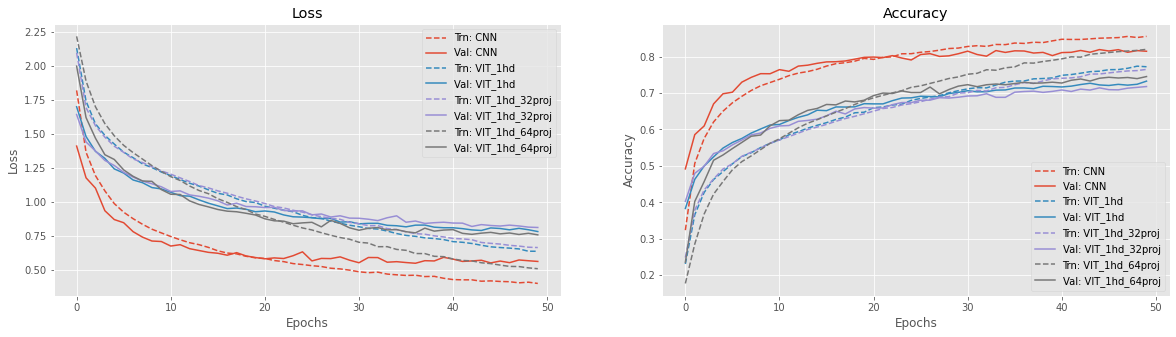

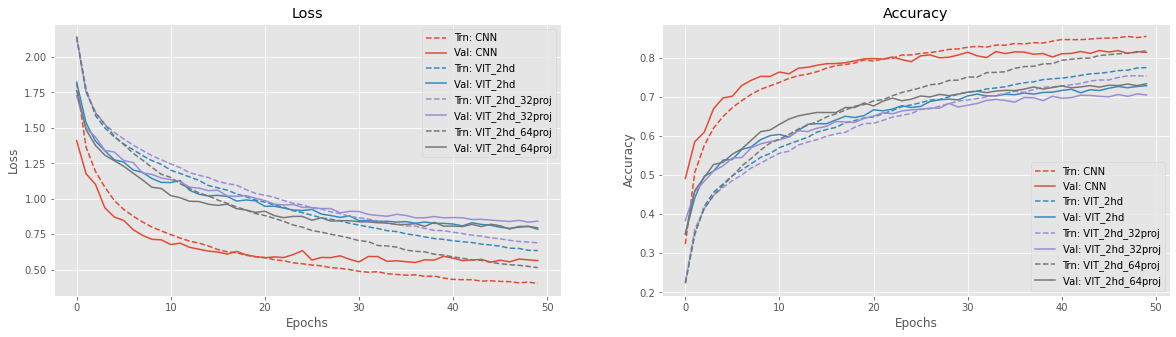

In [4]:
history = []
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN/history.npy', allow_pickle='TRUE').item())
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd/history.npy', allow_pickle='TRUE').item())
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_32proj/history.npy', allow_pickle='TRUE').item())
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_1hd_64proj/history.npy', allow_pickle='TRUE').item())

legends = ['CNN', 
           'VIT_1hd', 'VIT_1hd_32proj', 'VIT_1hd_64proj']
plot([(i['loss'], i['val_loss']) for i in history], 
     [(i['sparse_categorical_accuracy'],
       i['val_sparse_categorical_accuracy']) for i in history],
     legends,
     subplot_title=['Loss', 'Accuracy'])

history = []
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN/history.npy', allow_pickle='TRUE').item())
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/history.npy', allow_pickle='TRUE').item())
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_32proj/history.npy', allow_pickle='TRUE').item())
history.append(np.load('/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_64proj/history.npy', allow_pickle='TRUE').item())

legends = ['CNN', 
           'VIT_2hd', 'VIT_2hd_32proj', 'VIT_2hd_64proj']
plot([(i['loss'], i['val_loss']) for i in history], 
     [(i['sparse_categorical_accuracy'],
       i['val_sparse_categorical_accuracy']) for i in history],
     legends,
     subplot_title=['Loss', 'Accuracy'])